# Data Exploration

## Imports

In [2]:
import pandas as pd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

## Import Files

In [5]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,Nieuwmarkt Lat,Nieuwmarkt Lon,Nieuwezijds Kolk Lat,Nieuwezijds Kolk Lon,Dam Lat,Dam Lon,Spui Lat,Spui Lon,...,Nieuwmarkt score,Nieuwmarkt weight,Nieuwezijds Kolk score,Nieuwezijds Kolk weight,Dam score,Dam weight,Spui score,Spui weight,Centraal Station score,Centraal Station weight
0,2018-03-11,100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.000000,0.882141,0.000000,0.587521,-7.303229,-0.070905,-0.000000,-0.681885,163.979432,0.346680
1,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,352.242355,1.015108,83.818351,0.421198,-448.251594,-0.353790,-130.349893,-0.972760,1668.972914,0.432376
2,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,384.307873,1.107515,8.440208,0.042413,-1899.118958,-1.498910,-352.192566,-2.628303,3994.026550,1.034722
3,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,342.287655,1.049962,42.314730,0.253382,-1231.740805,-1.207589,-279.710090,-2.350505,3446.831541,1.043862
4,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,343.524310,1.053756,73.166332,0.438122,-730.059884,-0.715745,-196.552679,-1.651703,2770.301154,0.838977


In [4]:
full_df.columns

Index(['Date', 'Hour', 'Nieuwmarkt Lat', 'Nieuwmarkt Lon',
       'Nieuwezijds Kolk Lat', 'Nieuwezijds Kolk Lon', 'Dam Lat', 'Dam Lon',
       'Spui Lat', 'Spui Lon', 'Centraal Station Lat', 'Centraal Station Lon',
       'weekday', 'is_weekend', 'Sensor', 'SensorLongitude', 'SensorLatitude',
       'CrowdednessCount', 'LonScaled', 'LatScaled', 'is_event', 'Year',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'Nieuwmarkt score', 'Nieuwmarkt weight', 'Nieuwezijds Kolk score',
       'Nieuwezijds Kolk weight', 'Dam score', 'Dam weight', 'Spui score',
       'Spui weight', 'Centraal Station score', 'Centraal Station weight'],
      dtype='object')

## GVB

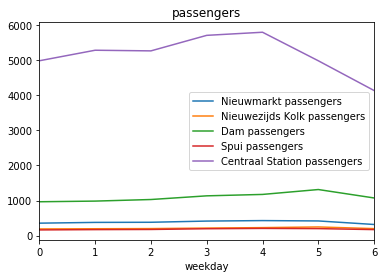

In [67]:
stations = ["Nieuwmarkt", "Nieuwezijds Kolk", "Dam", "Spui", "Centraal Station"]

for station in stations:
    full_df[station + " passengers"] = full_df[station +" score"] / full_df[station +" weight"]

df = full_df[["weekday", "Nieuwmarkt passengers", "Nieuwezijds Kolk passengers", "Dam passengers",
             "Spui passengers", "Centraal Station passengers"]].groupby(["weekday"]).agg(
            {"Nieuwmarkt passengers": "mean", 
             "Nieuwezijds Kolk passengers": "mean", 
             "Dam passengers": "mean",
             "Spui passengers": "mean", 
             "Centraal Station passengers": "mean"}).reset_index()

df.plot(x="weekday", title="passengers")
plt.savefig('../../../Data_thesis/Useful/passenger_counts.png')

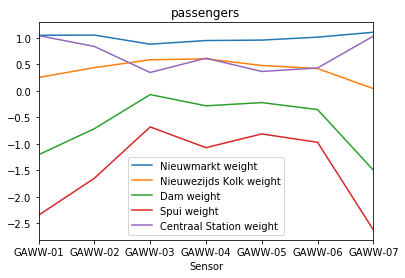

In [68]:
df = full_df[["Sensor", "Nieuwmarkt weight", "Nieuwezijds Kolk weight", "Dam weight",
             "Spui weight", "Centraal Station weight"]].groupby(["Sensor"]).agg(
            {"Nieuwmarkt weight": "mean", 
             "Nieuwezijds Kolk weight": "mean", 
             "Dam weight": "mean",
             "Spui weight": "mean", 
             "Centraal Station weight": "mean"}).reset_index()

df.plot(x="Sensor", title="weights")
plt.savefig('../../../Data_thesis/Useful/station_weights.png')

## CMSA 

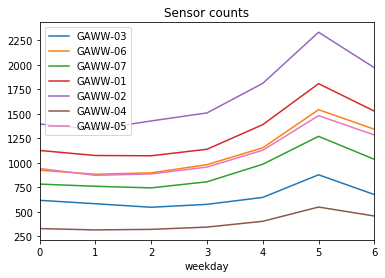

In [69]:
df_dict = {}

for sensor in full_df["Sensor"].unique():
    df = full_df[full_df["Sensor"] == sensor][["Sensor", "CrowdednessCount", 
                                                       "weekday"]].groupby(["Sensor", "weekday"]).agg(
        {"CrowdednessCount": "mean"}).reset_index()
    temp_dict = df.to_dict(orient="index")
    CrowdednessCount_list = []
    weekday_list = []
    for k,v in temp_dict.items():
        weekday_list.append(v["weekday"])
        CrowdednessCount_list.append(v["CrowdednessCount"])
    
    if "weekday" not in df_dict:
        df_dict["weekday"] = weekday_list
        
    df_dict[v["Sensor"]] = CrowdednessCount_list
    

df = pd.DataFrame.from_dict(df_dict)

df.plot(x="weekday", title="Sensor counts")
plt.savefig('../../../Data_thesis/Useful/sensor_counts.png')

## Map

In [3]:
street_map = gpd.read_file("../../../Data_thesis/MapShapeFiles/roads.shp")
crs = {"init": "epsg:4326"}

In [6]:
gvb_cor_dict = {}

gvb_dict = full_df.to_dict("index")

gvb_cor_dict["Nieuwmarkt"] = {"Latitude": gvb_dict[0]["Nieuwmarkt Lat"], "Longitude": gvb_dict[0]["Nieuwmarkt Lon"]}
gvb_cor_dict["Nieuwezijdse Kolk"] = {"Latitude": gvb_dict[0]["Nieuwezijds Kolk Lat"], 
                                         "Longitude": gvb_dict[0]["Nieuwezijds Kolk Lon"]}
gvb_cor_dict["Dam"] = {"Latitude": gvb_dict[0]["Dam Lat"], "Longitude": gvb_dict[0]["Dam Lon"]}
gvb_cor_dict["Spui"] = {"Latitude": gvb_dict[0]["Spui Lat"], "Longitude": gvb_dict[0]["Spui Lon"]}
gvb_cor_dict["Centraal Station"] = {"Latitude": gvb_dict[0]["Centraal Station Lat"], "Longitude": gvb_dict[0]["Centraal Station Lon"]}

gvb_cor_df = pd.DataFrame.from_dict(gvb_cor_dict, orient="index").reset_index()
gvb_cor_df = gvb_cor_df.rename(index=str, columns={"index": "Station"})

In [7]:
sensor_geometry = [Point(xy) for xy in zip(full_df["SensorLongitude"], full_df["SensorLatitude"])]
gvb_geometry = [Point(xy) for xy in zip(gvb_cor_df["Longitude"], gvb_cor_df["Latitude"])]

In [8]:
sensor_geo_df = gpd.GeoDataFrame(full_df, crs = crs,geometry = sensor_geometry)
sensor_geo_df = sensor_geo_df[["Sensor", "geometry"]]

gvb_geo_df = gpd.GeoDataFrame(gvb_cor_df, crs = crs,geometry = gvb_geometry)
gvb_geo_df = gvb_geo_df[["Station", "geometry"]]

In [13]:
sensor_geo_df.head()

,Sensor,geometry
0,GAWW-03,POINT (4.8973336 52.3725237)
1,GAWW-06,POINT (4.898053099999999 52.37241599999999)
2,GAWW-07,POINT (4.9004405 52.37441389999999)
3,GAWW-01,POINT (4.8998471 52.3746006)
4,GAWW-02,POINT (4.8989027 52.3737857)


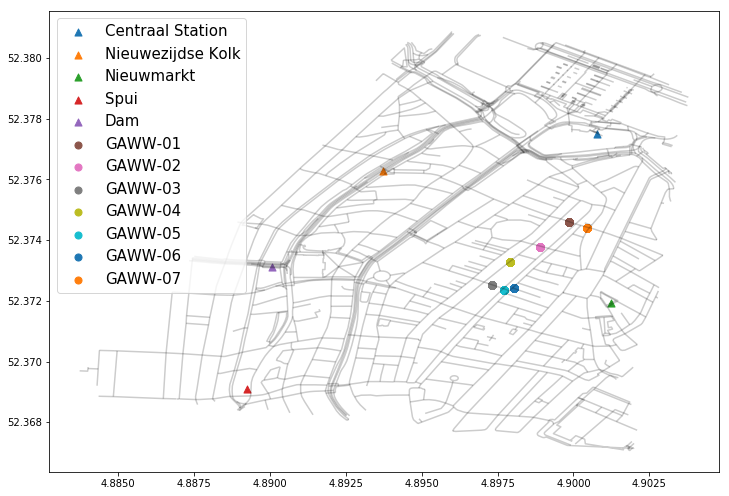

In [14]:
fig,ax = plt.subplots(figsize = (12, 12))
street_map.plot(ax = ax, alpha = 0.2, color = "black")

gvb_geo_df[gvb_geo_df["Station"] == "Centraal Station"].plot(ax = ax, markersize = 50, marker = "^", 
                                                        label = "Centraal Station")
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwezijdse Kolk"].plot(ax = ax, markersize = 50, marker = "^", 
                                                        label = "Nieuwezijdse Kolk")
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwmarkt"].plot(ax = ax, markersize = 50, marker = "^", 
                                                        label = "Nieuwmarkt")
gvb_geo_df[gvb_geo_df["Station"] == "Spui"].plot(ax = ax, markersize = 50, marker = "^", 
                                                        label = "Spui")
gvb_geo_df[gvb_geo_df["Station"] == "Dam"].plot(ax = ax, markersize = 50, marker = "^", 
                                                        label = "Dam")

sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-01"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-01")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-02"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-02")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-03"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-03")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-04"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-04")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-05"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-05")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-06"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-06")
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-07"].plot(ax = ax, markersize = 50, marker = "o", 
                                                       label = "GAWW-07")

plt.legend(prop={"size": 15})
plt.savefig('../../../Data_thesis/Useful/map.png')